<!-- <a href="https://colab.research.google.com/drive/1JbMpw_nQaCq5WAZmY0iDWVEWWV4cgH9H?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> -->

# Tissue Multi Classifier through esophagus microscopic images

Data Challenge by Mauna Kea (Challenge Link: https://challengedata.ens.fr/participants/challenges/11/)

## Load required libraries

In [1]:
%matplotlib inline

import os
import sys
import csv        
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

## CNN Training

In [2]:
# Pytorch
import torch, torchvision, torch.utils
import torch.backends.cudnn
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Flatten,
    Dropout, Dropout2d,
    CrossEntropyLoss,
    MaxPool2d, MaxPool1d,
    BatchNorm2d, BatchNorm1d
)
import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from tqdm.notebook import tqdm

In [3]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

### GPU Info

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [5]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 
  
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
# from subprocess import call
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
! nvidia-smi
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print('Available devices ', torch.cuda.device_count())
print('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]
__pyTorch VERSION: 1.13.1+cu117
__CUDA VERSION
Fri Feb  3 18:48:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8     5W /  50W |    977MiB /  4096MiB |     21%      Default |
|                               |                      |                  N/A |
+---------------------

## Classified Images can be download from:
https://github.com/contepablod/QCNNCancerMultiClassifier/tree/master/ClassifiedImages

We read them from local disk:

In [6]:
IMAGE_DIR_TRAIN = 'C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\DL\\RedesConvolucionales\\Mauna_Kea\\MultiClassifier\\ClassifiedImages\\Train'
IMAGE_DIR_VAL = 'C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\DL\\RedesConvolucionales\\Mauna_Kea\\MultiClassifier\\ClassifiedImages\\Val'

Data Augmentation and Transforms

In [7]:
resize = [130,130]

trans_normal = transforms.Compose([])
trans_normal.transforms.append(transforms.Resize(resize))
trans_normal.transforms.append(transforms.ToTensor())
trans_normal.transforms.append(
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
#trans_normal.transforms.append(Cutout(n_holes=1, length=32))

# trans_normal = transforms.Compose([
#    transforms.Resize(resize),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])
#trans_normal = transforms.ToTensor()

In [8]:
normal_dataset_train = torchvision.datasets.ImageFolder(IMAGE_DIR_TRAIN, transform=trans_normal)
normal_dataset_val = torchvision.datasets.ImageFolder(IMAGE_DIR_VAL, transform=trans_normal)

Input Tensor Dimension

In [9]:
normal_dataset_train[0][0].shape

torch.Size([3, 130, 130])

DataLoader

In [10]:
batch_size = 64

train_loader = DataLoader(normal_dataset_train,
                          shuffle=True, 
                          batch_size=batch_size,
                          pin_memory=True)

val_loader = DataLoader(normal_dataset_val,
                        shuffle=True, 
                        batch_size=batch_size,
                        pin_memory=True)

In [11]:
from collections import Counter
print(f'Classes: {train_loader.dataset.class_to_idx}')
num_classes_train = Counter(train_loader.dataset.targets)
num_classes_val = Counter(val_loader.dataset.targets)
print(f'Train Loader: {num_classes_train}')
print(f'Val Loader: {num_classes_val}')

Classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Train Loader: Counter({3: 3594, 1: 2723, 0: 1469, 2: 1206})
Val Loader: Counter({3: 1861, 1: 1335, 2: 1001, 0: 401})


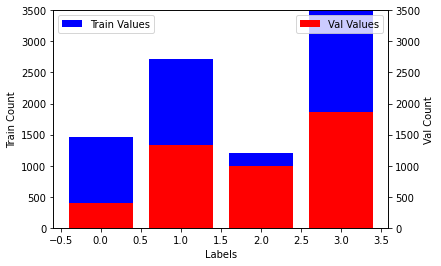

In [12]:
# Create the plot
fig, ax = plt.subplots()

# Plot the train values
ax.bar(num_classes_train.keys(), num_classes_train.values(),
       color='blue', label='Train Values')
ax.set_xlabel('Labels')
ax.set_ylabel('Train Count')
ax.set_ylim(0, 3500)

# Add a second y-axis for the val values
ax2 = ax.twinx()
ax2.bar(num_classes_val.keys(), num_classes_val.values(),
        color='red', label='Val Values')
ax2.set_ylabel('Val Count')
ax2.set_ylim(0, 3500)

# Add a legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


## Show Images

In [13]:
def show_images(num_samples, loader):
    data_iter = iter(loader)
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20, 20))
    while num_samples > 0:
        images, targets = data_iter.__next__()
        axes[num_samples - 1].imshow(images[0, 0].numpy().squeeze())
        axes[num_samples - 1].set_xticks([])
        axes[num_samples - 1].set_yticks([])
        axes[num_samples - 1].set_title(f"Tag: {targets[0]}")
        num_samples -= 1

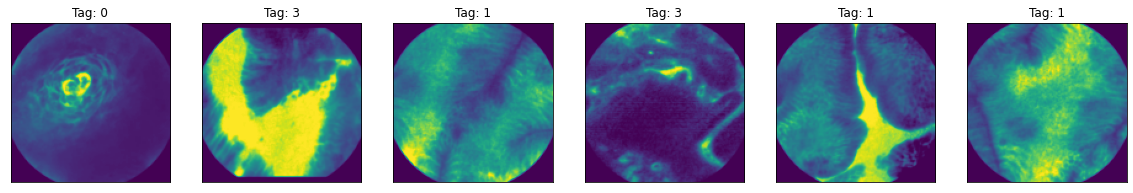

In [14]:
show_images(6, train_loader)

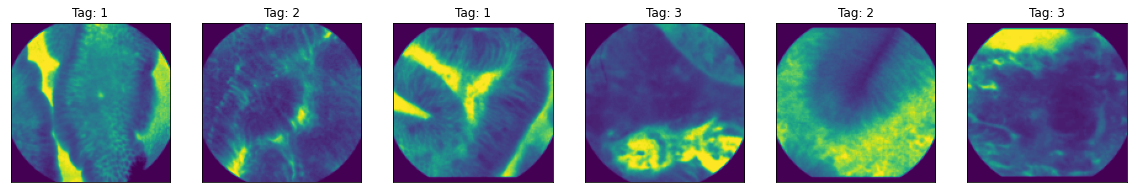

In [15]:
show_images(6, val_loader)

### Pytorch Neural Net Definition 

In [16]:
# Pytorch Neural Net
do = 0.1
out = 64
kernel = 3
targets = 4

class ImageClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv2D1 = Conv2d(3, out, kernel_size=kernel, padding=0, bias=False)
        self.conv2D2 = Conv2d(out, out*2, kernel_size=kernel, padding=0, bias=False)
        self.conv2D3 = Conv2d(out*2, out*4, kernel_size=kernel, padding=0, bias=False)
        self.conv2D4 = Conv2d(out*4, out*8, kernel_size=kernel, padding=0, bias=False)
        self.bn2D1 = BatchNorm2d(out)
        self.bn2D2 = BatchNorm2d(out*2)
        self.bn2D3 = BatchNorm2d(out*4)
        self.bn2D4 = BatchNorm2d(out*8)
        self.dropout2D = Dropout2d(do)
        self.maxpool = MaxPool2d(kernel_size=kernel-1, stride=2)
        self.flatten = Flatten()
        self.dense1 = Linear(18432, out*8)
        self.dense2 = Linear(out*8, out*4)
        self.dense3 = Linear(out*4, out*2)
        self.bn1 = BatchNorm1d(out*8)
        self.bn2 = BatchNorm1d(out*4)
        self.bn3 = BatchNorm1d(out*2)
        self.dense4 = Linear(out*2, targets)
        self.dropout1D = Dropout(do)


    def forward(self, x):
        x = self.maxpool(self.bn2D1(self.conv2D1(x)))
        x = self.dropout2D(x)
        x = self.maxpool(self.bn2D2(self.conv2D2(x)))
        x = self.dropout2D(x)
        x = self.maxpool(self.bn2D3(self.conv2D3(x)))
        x = self.dropout2D(x)
        x = self.maxpool(self.bn2D4(self.conv2D4(x)))
        x = self.dropout2D(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.dense1(x)))
        x = self.dropout1D(x)
        x = F.relu(self.bn2(self.dense2(x)))
        x = self.dropout1D(x)
        x = F.relu(self.bn3(self.dense3(x)))
        x = self.dropout1D(x)
        x = self.dense4(x)
        return x

In [17]:
model = ImageClassifier()

### Show Model

In [18]:
summary(model.to('cuda'), (3, resize[0], resize[1]),
        batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 128, 128]           1,728
       BatchNorm2d-2         [64, 64, 128, 128]             128
         MaxPool2d-3           [64, 64, 64, 64]               0
         Dropout2d-4           [64, 64, 64, 64]               0
            Conv2d-5          [64, 128, 62, 62]          73,728
       BatchNorm2d-6          [64, 128, 62, 62]             256
         MaxPool2d-7          [64, 128, 31, 31]               0
         Dropout2d-8          [64, 128, 31, 31]               0
            Conv2d-9          [64, 256, 29, 29]         294,912
      BatchNorm2d-10          [64, 256, 29, 29]             512
        MaxPool2d-11          [64, 256, 14, 14]               0
        Dropout2d-12          [64, 256, 14, 14]               0
           Conv2d-13          [64, 512, 12, 12]       1,179,648
      BatchNorm2d-14          [64, 512,

In [19]:
# dummy_tensor = next(iter(train_loader))[0].to('cuda')
# make_dot(model(dummy_tensor), params=dict(list(model.named_parameters())), show_saved=True, show_attrs=True).render("rnn_torchviz.png", format="png")
# #display.Image('https://raw.githubusercontent.com/contepablod/QCNNCancerClassifier/master/rnn_torchviz.png')
# display.Image("rnn_torchviz.png", width=2000, height=2250)

### Optimisation, Loss Function and Early Stopping Definition

In [20]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta


    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            #print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        return self.early_stop


    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation Loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving Checkpoint Model ...')
        torch.save(model.state_dict(), f'checkpoint_4L_4D_D{do}.pt')
        self.val_loss_min = val_loss

In [21]:
# Tunners
learning_rate = 0.00001

optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                        amsgrad=True, weight_decay=learning_rate*0.1)

#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                        #nesterov=True, weight_decay=learning_rate*0.1, momentum=0.9)

loss_func = CrossEntropyLoss().to('cuda')

epochs = 50

early_stopping = EarlyStopping(patience=int(epochs*0.5), verbose=True)

#lr_scheduler = optim.lr_scheduler.StepLR(
    #optimizer, step_size=10, gamma=0.1, last_epoch=- 1)


### Training

In [22]:
def train_eval(model, loader, optimizer, loss_func):
    correct_train = 0
    total_loss_train = []
    correct_val = 0
    total_loss_val = []
    #Model in training mode:
    if model.training:
        for batch_idx, (data, target) in tqdm(enumerate(loader), desc='Epoch_Train', total=len(loader)):
            optimizer.zero_grad(set_to_none=True)
            output = model(data.to('cuda'))
            loss_train = loss_func(output, target.to('cuda'))
            loss_train.backward()
            optimizer.step()
            #lr_scheduler.step()
            total_loss_train.append(loss_train.item())
            train_pred = output.argmax(dim=1, keepdim=True)
            correct_train += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
        return total_loss_train, correct_train
    #Model in evaluation mode:
    elif not model.training:
        for batch_idx, (data, target) in tqdm(enumerate(loader), desc='Epoch_Val', total=len(loader)):
            output = model(data.to('cuda'))
            loss_val = loss_func(output, target.to('cuda'))
            total_loss_val.append(loss_val.item())
            train_pred = output.argmax(dim=1, keepdim = True)
            correct_val += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
        stop = early_stopping((sum(total_loss_val) / len(total_loss_val)), model)
        return total_loss_val, correct_val, stop


def calc_acc_loss(loss_list, total_accuracy, total_loss, correct, loader):
    loss_list.append(sum(total_loss) / len(total_loss))
    total_accuracy.append(100 * correct / (loader.batch_size*len(loader)))
    return loss_list, total_accuracy

In [23]:
%%time

# Lists
loss_list_train = []  
loss_list_val = []
total_accuracy_train = []
total_accuracy_val = []

#Training and Evaluation
for epoch in range(epochs):
    #Train Iterations
    model = model.train().to('cuda')
    total_loss_train, correct_train = train_eval(model, train_loader, optimizer, loss_func)
    #Val Iterations
    model = model.eval().to('cuda')
    with torch.no_grad():
        total_loss_val, correct_val, stop = train_eval(model, val_loader, optimizer, loss_func)
    if stop:
        print('Early Stopping')
        break
    #Train Calc Loss & Acccuracy
    loss_list_train, total_accuracy_train = calc_acc_loss(loss_list_train, total_accuracy_train, total_loss_train, correct_train, train_loader)
    #Val Calc Loss & Accuracy
    loss_list_val,total_accuracy_val = calc_acc_loss(loss_list_val, total_accuracy_val, total_loss_val, correct_val, val_loader)
    #Printing Metrics per Epoch
    print(f"Training [{100.0 *(epoch+1)/epochs:.0f}%]\t\tTrain Loss:{loss_list_train[-1]:.4f}  Val Loss:{loss_list_val[-1]:.4f}\tTrain Accuracy:{total_accuracy_train[-1]:.2f}%  Val Accuracy:{total_accuracy_val[-1]:.2f}%")

Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (inf --> 1.1551).  Saving Checkpoint Model ...
Training [2%]		Train Loss:1.1776  Val Loss:1.1551	Train Accuracy:48.33%  Val Accuracy:52.30%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (1.1551 --> 1.0798).  Saving Checkpoint Model ...
Training [4%]		Train Loss:0.9785  Val Loss:1.0798	Train Accuracy:62.10%  Val Accuracy:57.14%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (1.0798 --> 0.9716).  Saving Checkpoint Model ...
Training [6%]		Train Loss:0.8668  Val Loss:0.9716	Train Accuracy:68.56%  Val Accuracy:64.95%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.9716 --> 0.9231).  Saving Checkpoint Model ...
Training [8%]		Train Loss:0.7829  Val Loss:0.9231	Train Accuracy:73.64%  Val Accuracy:67.45%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.9231 --> 0.8583).  Saving Checkpoint Model ...
Training [10%]		Train Loss:0.7123  Val Loss:0.8583	Train Accuracy:76.99%  Val Accuracy:71.07%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.8583 --> 0.7872).  Saving Checkpoint Model ...
Training [12%]		Train Loss:0.6567  Val Loss:0.7872	Train Accuracy:79.53%  Val Accuracy:74.50%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.7872 --> 0.7649).  Saving Checkpoint Model ...
Training [14%]		Train Loss:0.6068  Val Loss:0.7649	Train Accuracy:81.77%  Val Accuracy:75.63%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.7649 --> 0.7136).  Saving Checkpoint Model ...
Training [16%]		Train Loss:0.5580  Val Loss:0.7136	Train Accuracy:83.57%  Val Accuracy:77.39%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.7136 --> 0.6646).  Saving Checkpoint Model ...
Training [18%]		Train Loss:0.5224  Val Loss:0.6646	Train Accuracy:85.17%  Val Accuracy:80.03%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.6646 --> 0.6165).  Saving Checkpoint Model ...
Training [20%]		Train Loss:0.4838  Val Loss:0.6165	Train Accuracy:86.35%  Val Accuracy:81.27%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.6165 --> 0.5798).  Saving Checkpoint Model ...
Training [22%]		Train Loss:0.4538  Val Loss:0.5798	Train Accuracy:87.64%  Val Accuracy:83.07%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.5798 --> 0.5560).  Saving Checkpoint Model ...
Training [24%]		Train Loss:0.4299  Val Loss:0.5560	Train Accuracy:88.11%  Val Accuracy:84.03%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.5560 --> 0.5214).  Saving Checkpoint Model ...
Training [26%]		Train Loss:0.3975  Val Loss:0.5214	Train Accuracy:89.77%  Val Accuracy:84.61%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.5214 --> 0.4904).  Saving Checkpoint Model ...
Training [28%]		Train Loss:0.3760  Val Loss:0.4904	Train Accuracy:90.00%  Val Accuracy:85.13%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.4904 --> 0.4450).  Saving Checkpoint Model ...
Training [30%]		Train Loss:0.3471  Val Loss:0.4450	Train Accuracy:91.29%  Val Accuracy:87.59%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [32%]		Train Loss:0.3273  Val Loss:0.4492	Train Accuracy:91.90%  Val Accuracy:87.61%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.4450 --> 0.4150).  Saving Checkpoint Model ...
Training [34%]		Train Loss:0.3069  Val Loss:0.4150	Train Accuracy:92.53%  Val Accuracy:87.98%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.4150 --> 0.4020).  Saving Checkpoint Model ...
Training [36%]		Train Loss:0.2844  Val Loss:0.4020	Train Accuracy:93.59%  Val Accuracy:88.93%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.4020 --> 0.3881).  Saving Checkpoint Model ...
Training [38%]		Train Loss:0.2661  Val Loss:0.3881	Train Accuracy:94.00%  Val Accuracy:88.91%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.3881 --> 0.3561).  Saving Checkpoint Model ...
Training [40%]		Train Loss:0.2574  Val Loss:0.3561	Train Accuracy:94.09%  Val Accuracy:89.95%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.3561 --> 0.3524).  Saving Checkpoint Model ...
Training [42%]		Train Loss:0.2420  Val Loss:0.3524	Train Accuracy:94.67%  Val Accuracy:90.45%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.3524 --> 0.3357).  Saving Checkpoint Model ...
Training [44%]		Train Loss:0.2173  Val Loss:0.3357	Train Accuracy:95.48%  Val Accuracy:90.73%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.3357 --> 0.3212).  Saving Checkpoint Model ...
Training [46%]		Train Loss:0.2085  Val Loss:0.3212	Train Accuracy:95.73%  Val Accuracy:91.41%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [48%]		Train Loss:0.1956  Val Loss:0.3236	Train Accuracy:96.24%  Val Accuracy:91.21%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.3212 --> 0.3183).  Saving Checkpoint Model ...
Training [50%]		Train Loss:0.1864  Val Loss:0.3183	Train Accuracy:96.42%  Val Accuracy:91.43%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.3183 --> 0.2806).  Saving Checkpoint Model ...
Training [52%]		Train Loss:0.1805  Val Loss:0.2806	Train Accuracy:96.32%  Val Accuracy:92.19%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [54%]		Train Loss:0.1689  Val Loss:0.2977	Train Accuracy:96.76%  Val Accuracy:91.67%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [56%]		Train Loss:0.1570  Val Loss:0.2824	Train Accuracy:96.97%  Val Accuracy:92.23%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2806 --> 0.2695).  Saving Checkpoint Model ...
Training [58%]		Train Loss:0.1442  Val Loss:0.2695	Train Accuracy:97.58%  Val Accuracy:92.47%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2695 --> 0.2649).  Saving Checkpoint Model ...
Training [60%]		Train Loss:0.1417  Val Loss:0.2649	Train Accuracy:97.46%  Val Accuracy:92.58%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [62%]		Train Loss:0.1288  Val Loss:0.2657	Train Accuracy:98.05%  Val Accuracy:92.47%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2649 --> 0.2408).  Saving Checkpoint Model ...
Training [64%]		Train Loss:0.1260  Val Loss:0.2408	Train Accuracy:97.81%  Val Accuracy:93.12%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [66%]		Train Loss:0.1201  Val Loss:0.2531	Train Accuracy:98.08%  Val Accuracy:92.84%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [68%]		Train Loss:0.1144  Val Loss:0.2560	Train Accuracy:98.09%  Val Accuracy:92.38%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [70%]		Train Loss:0.1118  Val Loss:0.2613	Train Accuracy:98.24%  Val Accuracy:92.56%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2408 --> 0.2384).  Saving Checkpoint Model ...
Training [72%]		Train Loss:0.1029  Val Loss:0.2384	Train Accuracy:98.46%  Val Accuracy:93.14%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [74%]		Train Loss:0.1006  Val Loss:0.2476	Train Accuracy:98.18%  Val Accuracy:92.82%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2384 --> 0.2343).  Saving Checkpoint Model ...
Training [76%]		Train Loss:0.0935  Val Loss:0.2343	Train Accuracy:98.61%  Val Accuracy:93.01%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2343 --> 0.2293).  Saving Checkpoint Model ...
Training [78%]		Train Loss:0.0927  Val Loss:0.2293	Train Accuracy:98.59%  Val Accuracy:93.14%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [80%]		Train Loss:0.0867  Val Loss:0.2313	Train Accuracy:98.73%  Val Accuracy:93.01%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2293 --> 0.2229).  Saving Checkpoint Model ...
Training [82%]		Train Loss:0.0824  Val Loss:0.2229	Train Accuracy:98.93%  Val Accuracy:93.38%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [84%]		Train Loss:0.0764  Val Loss:0.2310	Train Accuracy:99.01%  Val Accuracy:93.01%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [86%]		Train Loss:0.0773  Val Loss:0.2471	Train Accuracy:98.89%  Val Accuracy:92.69%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Validation Loss decreased (0.2229 --> 0.2079).  Saving Checkpoint Model ...
Training [88%]		Train Loss:0.0769  Val Loss:0.2079	Train Accuracy:98.83%  Val Accuracy:93.62%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [90%]		Train Loss:0.0720  Val Loss:0.2296	Train Accuracy:98.96%  Val Accuracy:93.19%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [92%]		Train Loss:0.0665  Val Loss:0.2272	Train Accuracy:99.06%  Val Accuracy:93.06%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [94%]		Train Loss:0.0675  Val Loss:0.2116	Train Accuracy:98.88%  Val Accuracy:93.64%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [96%]		Train Loss:0.0638  Val Loss:0.2262	Train Accuracy:99.19%  Val Accuracy:93.12%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [98%]		Train Loss:0.0601  Val Loss:0.2296	Train Accuracy:99.17%  Val Accuracy:93.16%


Epoch_Train:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/72 [00:00<?, ?it/s]

Training [100%]		Train Loss:0.0593  Val Loss:0.2396	Train Accuracy:99.14%  Val Accuracy:92.66%
CPU times: total: 4h 25min 31s
Wall time: 2h 10s


### Convergence Plot

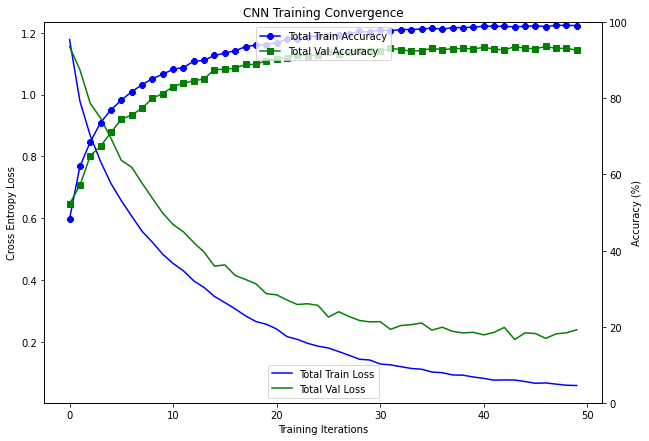

In [24]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(loss_list_train, 'b', label='Total Train Loss')
ax1.plot(loss_list_val, 'g', label='Total Val Loss')
ax1.legend(loc=8)
ax2 = ax1.twinx()
ax2.plot(total_accuracy_train, 'b', marker='8', label='Total Train Accuracy')
ax2.plot(total_accuracy_val, 'g', marker='s', label='Total Val Accuracy')
ax2.set_ylim(0, 100)
ax2.legend(loc=9)
plt.title("CNN Training Convergence", color='black')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='black')
ax2.set_ylabel("Accuracy (%)", color='black')
plt.show()

### Save Model

In [27]:
torch.save(model.state_dict(),f"CNN_{epochs}E_4CL_4DL_D{do}.pt")

### Load Model to Predict

In [28]:
model_pred = ImageClassifier()
model_pred.load_state_dict(torch.load(f"CNN_{epochs}E_4CL_4DL_D{do}.pt"))


<All keys matched successfully>

### Creates csv file containing filenames of test folders

In [29]:
def write_csv_file(path_folder, path_file, file):
    # Get a list of the filenames in the folder
    filenames = os.listdir(path_folder)
    # Open a CSV file for writing
    with open(path_file + '/' + file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write the filenames to the CSV file
        for filename in filenames:
            writer.writerow([filename])

In [30]:
#Test set Part1
path_folder_1 = r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TestSetImagesFull\part_1"
#Test set Part2
path_folder_2 = r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TestSetImagesFull\part_2"
path_file = r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TestSetImagesFull"
file_1 = 'TestSetImagesFullPart1.csv'
file_2 = 'TestSetImagesFullPart2.csv'
write_csv_file(path_folder_1, path_file, file_1)
write_csv_file(path_folder_2, path_file, file_2)

Creates helper functions to load images

In [31]:
def pil_loader(path):
    from PIL import Image
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except OSError:
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

### Creates Custom DataSet

In [32]:
class CustomImageDataset(Dataset):
    # transforms.Compose([transforms.Resize([260, 260])]):
    def __init__(self, annotations_file, img_dir, transform=trans_normal):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, str(filename))
        image = default_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, filename

In [33]:
path_filename_1 = r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TestSetImagesFull\TestSetImagesFullPart1.csv"
path_filename_2 = r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TestSetImagesFull\TestSetImagesFullPart2.csv"

In [34]:
testset_1 = CustomImageDataset(path_filename_1, path_folder_1)
testset_2 = CustomImageDataset(path_filename_2, path_folder_2)

In [35]:
test_loader = DataLoader(ConcatDataset([testset_1, testset_2]),
                                        shuffle=True, 
                                        batch_size=batch_size,
                                        pin_memory=True)

### Show Test Images

Test Set


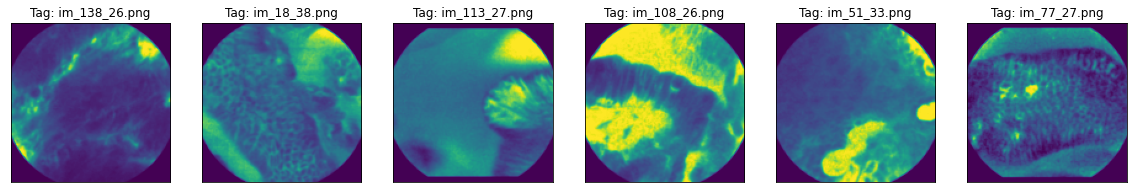

In [36]:
print('Test Set')
show_images(6, test_loader)

### Model Prediction

In [37]:
def eval(model, loader, dict_set):
    for batch_idx, (data, file) in tqdm(enumerate(loader), desc='Test Epoch', total=len(loader)):
        output = model(data.to('cuda'))
        if len(output.shape) == 1:
           output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for item in range(len(file)):
            dict_set[file[item]] = pred[item].item()          
    return dict_set

In [38]:
model_pred = model_pred.eval().to('cuda')
dict_set = {}

with no_grad():
    dict_set = eval(model_pred, test_loader, dict_set)

Test Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

In [39]:
test_data = pd.read_csv(
    r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\Mauna_Kea_Supp_Material\test_data_order.csv")

In [40]:
test_data = test_data.set_index('image_filename')

In [41]:
test_data['class_number'] = np.nan
for key in dict_set.keys():
    test_data['class_number'].loc[key] = int(dict_set[key])

In [42]:
test_data['class_number'] = test_data['class_number'].astype(int)

In [43]:
test_data.value_counts()

class_number
3               607
1               571
2               294
0               243
dtype: int64

### Test data prediction to csv

In [44]:
test_data.to_csv(f'testset_4L_4D_D{do}.csv')

Submission score is: 0.7983


# Referencias

1. Clasificador de Cáncer de Esófago - https://github.com/AnIsAsPe/ClassificadorCancerEsofago

2. - Machine Learning & IA for the Working Analyst - Colegio de Matemáticas Bourbaki - México
   - Especialización en Deep Learning - Colegio de Matemáticas Bourbaki - México
   - https://www.colegio-bourbaki.com/
   - LinkedIn: Colegio Bourbaki

3. PyTorch Performance Tuning Guide - Szymon Migacz, NVIDIA - https://www.youtube.com/watch?v=9mS1fIYj1So

4. PyTorch 101, Part 4: Memory Management and Using Multiple GPUs - Ayoosh Kathuria - https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/amp/

5. AdamW and Super-convergence is now the fastest way to train neural nets - Sylvain Gugger and Jeremy Howard - https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html#appendix-full-results 

6. Decoupled Weight Decay Regularization - Ilya Loshchilov & Frank Hutter - arXiv:1711.05101v3 